In [27]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt



import pickle

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Determine important landmarks for plank
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE",
    "LEFT_HEEL",
    "RIGHT_HEEL",
    "LEFT_FOOT_INDEX",
    "RIGHT_FOOT_INDEX",
]

# Generate all columns of the data frame

HEADERS = ["label"] # Label column

for lm in IMPORTANT_LMS:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [6]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data




def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))


df = describe_dataset("/content/drive/MyDrive/train_trest_bc/plank/train.csv")

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

In [7]:
# load dataset
df = pd.read_csv("/content/drive/MyDrive/train_trest_bc/plank/train.csv")

# Categorizing label
df.loc[df["label"] == "C", "label"] = 0
df.loc[df["label"] == "H", "label"] = 1
df.loc[df["label"] == "L", "label"] = 2

print(f'Number of rows: {df.shape[0]} \nNumber of columns: {df.shape[1]}\n')
print(f"Labels: \n{df['label'].value_counts()}\n")

Number of rows: 28520 
Number of columns: 69

Labels: 
0    9904
2    9546
1    9070
Name: label, dtype: int64



In [8]:
# Standard Scaling of features
# Dump input scaler
with open("/content/drive/MyDrive/train_trest_bc/plank/input_scaler.pkl", "rb") as f2:
    sc = pickle.load(f2)

x = df.drop("label", axis = 1)
x = pd.DataFrame(sc.transform(x))

y = df["label"]

# # Converting prediction to categorical
y_cat = to_categorical(y)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y_cat, test_size=0.2, random_state=1234)

In [10]:
stop_early = EarlyStopping(monitor='loss', patience=3)

# Final Results
final_models = {}

In [11]:
def describe_model(model):
    '''
    Describe Model architecture
    '''
    print(f"Describe models architecture")
    for i, layer in enumerate(model.layers):
        number_of_units = layer.units if hasattr(layer, 'units') else 0

        if hasattr(layer, "activation"):
            print(f"Layer-{i + 1}: {number_of_units} units, func: ", layer.activation)
        else:
            print(f"Layer-{i + 1}: {number_of_units} units, func: None")
            

def get_best_model(tuner):
    '''
    Describe and return the best model found from keras tuner
    '''
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)

    describe_model(best_model)

    print("\nOther params:")
    ignore_params = ["tuner", "activation", "layer"]
    for param, value in best_hps.values.items():
        if not any(word in param for word in ignore_params):
            print(f"{param}: {value}")

    return best_model

In [12]:
def model_builder(hp):
    model = Sequential()
    model.add(Dense(68, input_dim = 68, activation = "relu"))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=32, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=512, step=32)
    hp_layer_3 = hp.Int('layer_3', min_value=32, max_value=512, step=32)
    hp_layer_4 = hp.Int('layer_4', min_value=32, max_value=512, step=32)
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(Dense(units=hp_layer_1, activation=hp_activation))
    model.add(Dropout(rate=hp_dropout_1))
    model.add(Dense(units=hp_layer_2, activation=hp_activation))
    model.add(Dropout(rate=hp_dropout_2))
    model.add(Dense(units=hp_layer_3, activation=hp_activation))
    model.add(Dropout(rate=hp_dropout_3))
    model.add(Dense(units=hp_layer_4, activation=hp_activation))
    model.add(Dense(3, activation = "softmax"))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss="categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [14]:
tuner = kt.Hyperband(
    model_builder,
    objective='accuracy',
    max_epochs=10,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo_4'
)
tuner.search(x_train, y_train, epochs=10)

In [20]:
model= get_best_model(tuner)
history=model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), callbacks=[stop_early])

Describe models architecture
Layer-1: 68 units, func:  <function relu at 0x7f9b511ca440>
Layer-2: 512 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-3: 0 units, func: None
Layer-4: 416 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-5: 0 units, func: None
Layer-6: 512 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-7: 0 units, func: None
Layer-8: 352 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-9: 3 units, func:  <function softmax at 0x7f9b511c9a20>

Other params:
dropout_1: 0.30000000000000004
dropout_2: 0.1
dropout_3: 0.4
learning_rate: 0.0001
Epoch 1/100
2282/2282 [==============================] - 23s 10ms/step - loss: 0.0620 - accuracy: 0.9801 - val_loss: 0.0077 - val_accuracy: 0.9981
Epoch 2/100
2282/2282 [==============================] - 21s 9ms/step - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.0037 - val_accuracy: 0.9991
Epoch 3/100
2282/2282 [==============================] - 24s 10ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.0045 - v

In [16]:
describe_model(model)

Describe models architecture
Layer-1: 68 units, func:  <function relu at 0x7f9b511ca440>
Layer-2: 512 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-3: 0 units, func: None
Layer-4: 416 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-5: 0 units, func: None
Layer-6: 512 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-7: 0 units, func: None
Layer-8: 352 units, func:  <function tanh at 0x7f9b511ca7a0>
Layer-9: 3 units, func:  <function softmax at 0x7f9b511c9a20>


In [21]:
evaluate = model.evaluate(x=x_test,y=y_test)


179/179 [==============================] - 1s 4ms/step - loss: 0.0014 - accuracy: 0.9996


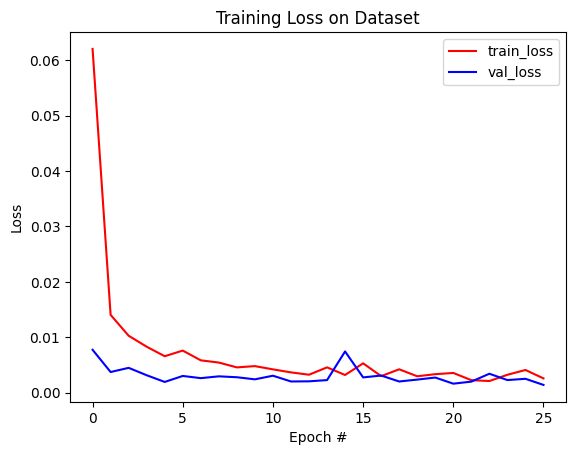

In [22]:
epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

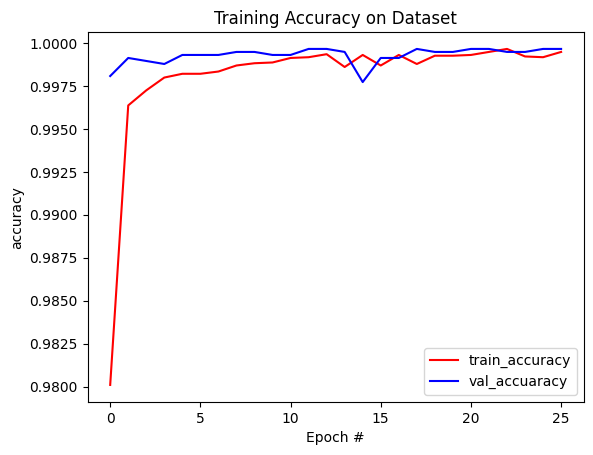

In [23]:
epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['accuracy'], 'red', label = 'train_accuracy')
plt.plot(epoch, history.history['val_accuracy'], 'blue', label = 'val_accuaracy')
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend()

In [26]:
model.save("/content/drive/MyDrive/train_trest_bc/plank/models/")

In [28]:
saved_model_path = "/content/drive/MyDrive/train_trest_bc/plank/models/"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

# Convert to TFLite model
tflite_model = converter.convert()

In [29]:
tflite_model_path = "/content/drive/MyDrive/train_trest_bc/plank/tflite/plank_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)